\newpage

## DSS Prototype Overview ##

### Installation as a Docker Container ###

https://github.com/jupyter/docker-stacks  
https://hub.docker.com/r/jupyter/r-notebook/tags/  

_(optional) docker pull jupyter/r-notebook:latest_  

We want the Jupyter container to mount the DDS Prototype ~/analysis/ directory to provide access to scripts and data. Use the following to mount the analysis directory (i.e. current working directory) as a volume in the Juypter container. Note that the directory needed to be added as a valid mount point via the Docker Desktop Dashboard on Mac.

_docker run -it --rm -d -p 10000:8888 -v ${PWD}:/home/jovyan/work --name notebook jupyter/r-notebook:latest_  

To find the token from the container:  
_docker exec -it notebook jupyter server list_  
or  
_docker logs notebook_

Navigate to the container UI and enter the token:
http://localhost:10000

### System Context ###

Figure 1 depicts the context for the DSS. The DSS operator interacts with the DSS Prototype for decision assitance. The DSS relies on a aircraft database to gather real-time flight data to review in decision support algorithms.

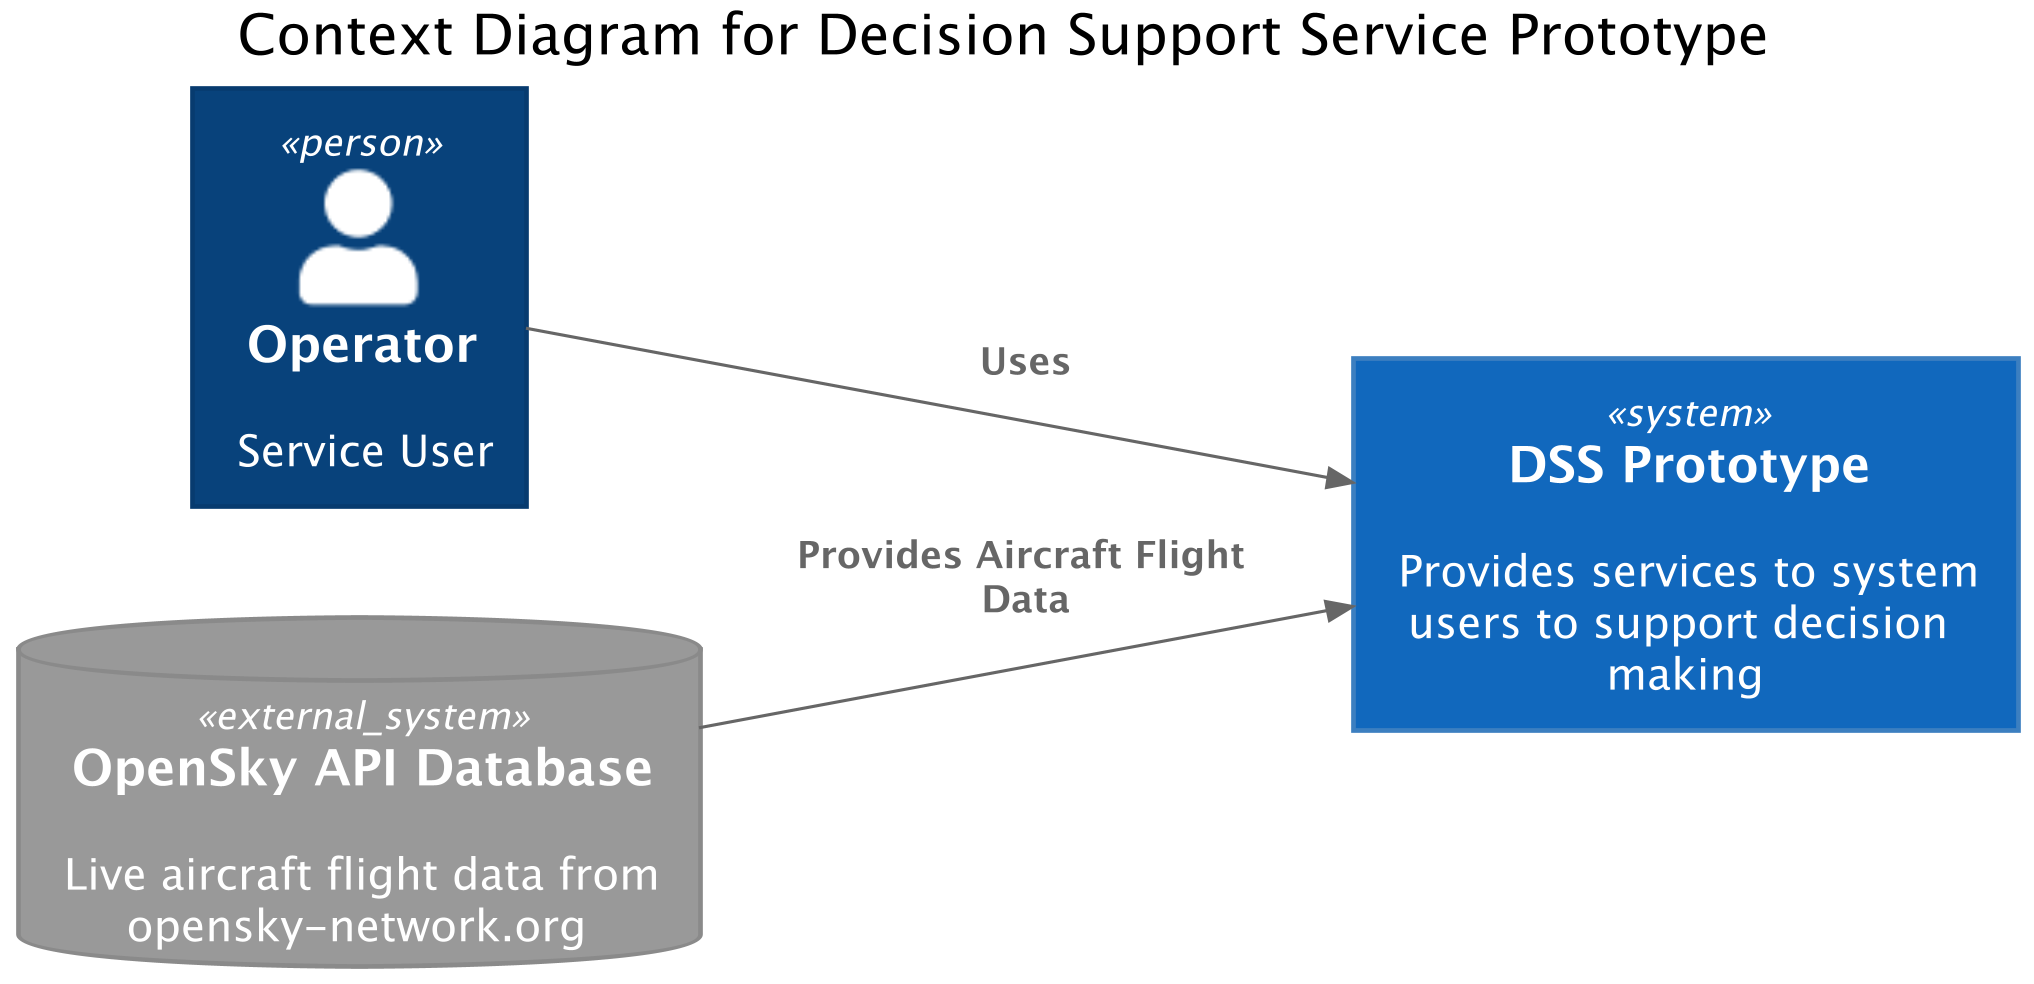

### Container Architecture ###

Nine containers are instantiated as part of the DSS architecuture (see Figure 2). Six provide the DSS implementation while the additional 3 support collection and calculation of metrics. Each application container was designed around the 12-Factor Application "Single Responsibility Principle"; e.g. each app has one purpose to enable rapid insertion of new capabilities with low cohesion to other functionality. At this time, all responses are canned without underlying calculations to focus on meeting the 500 ms hypothesis pryor to burdening the application with calculation latency.

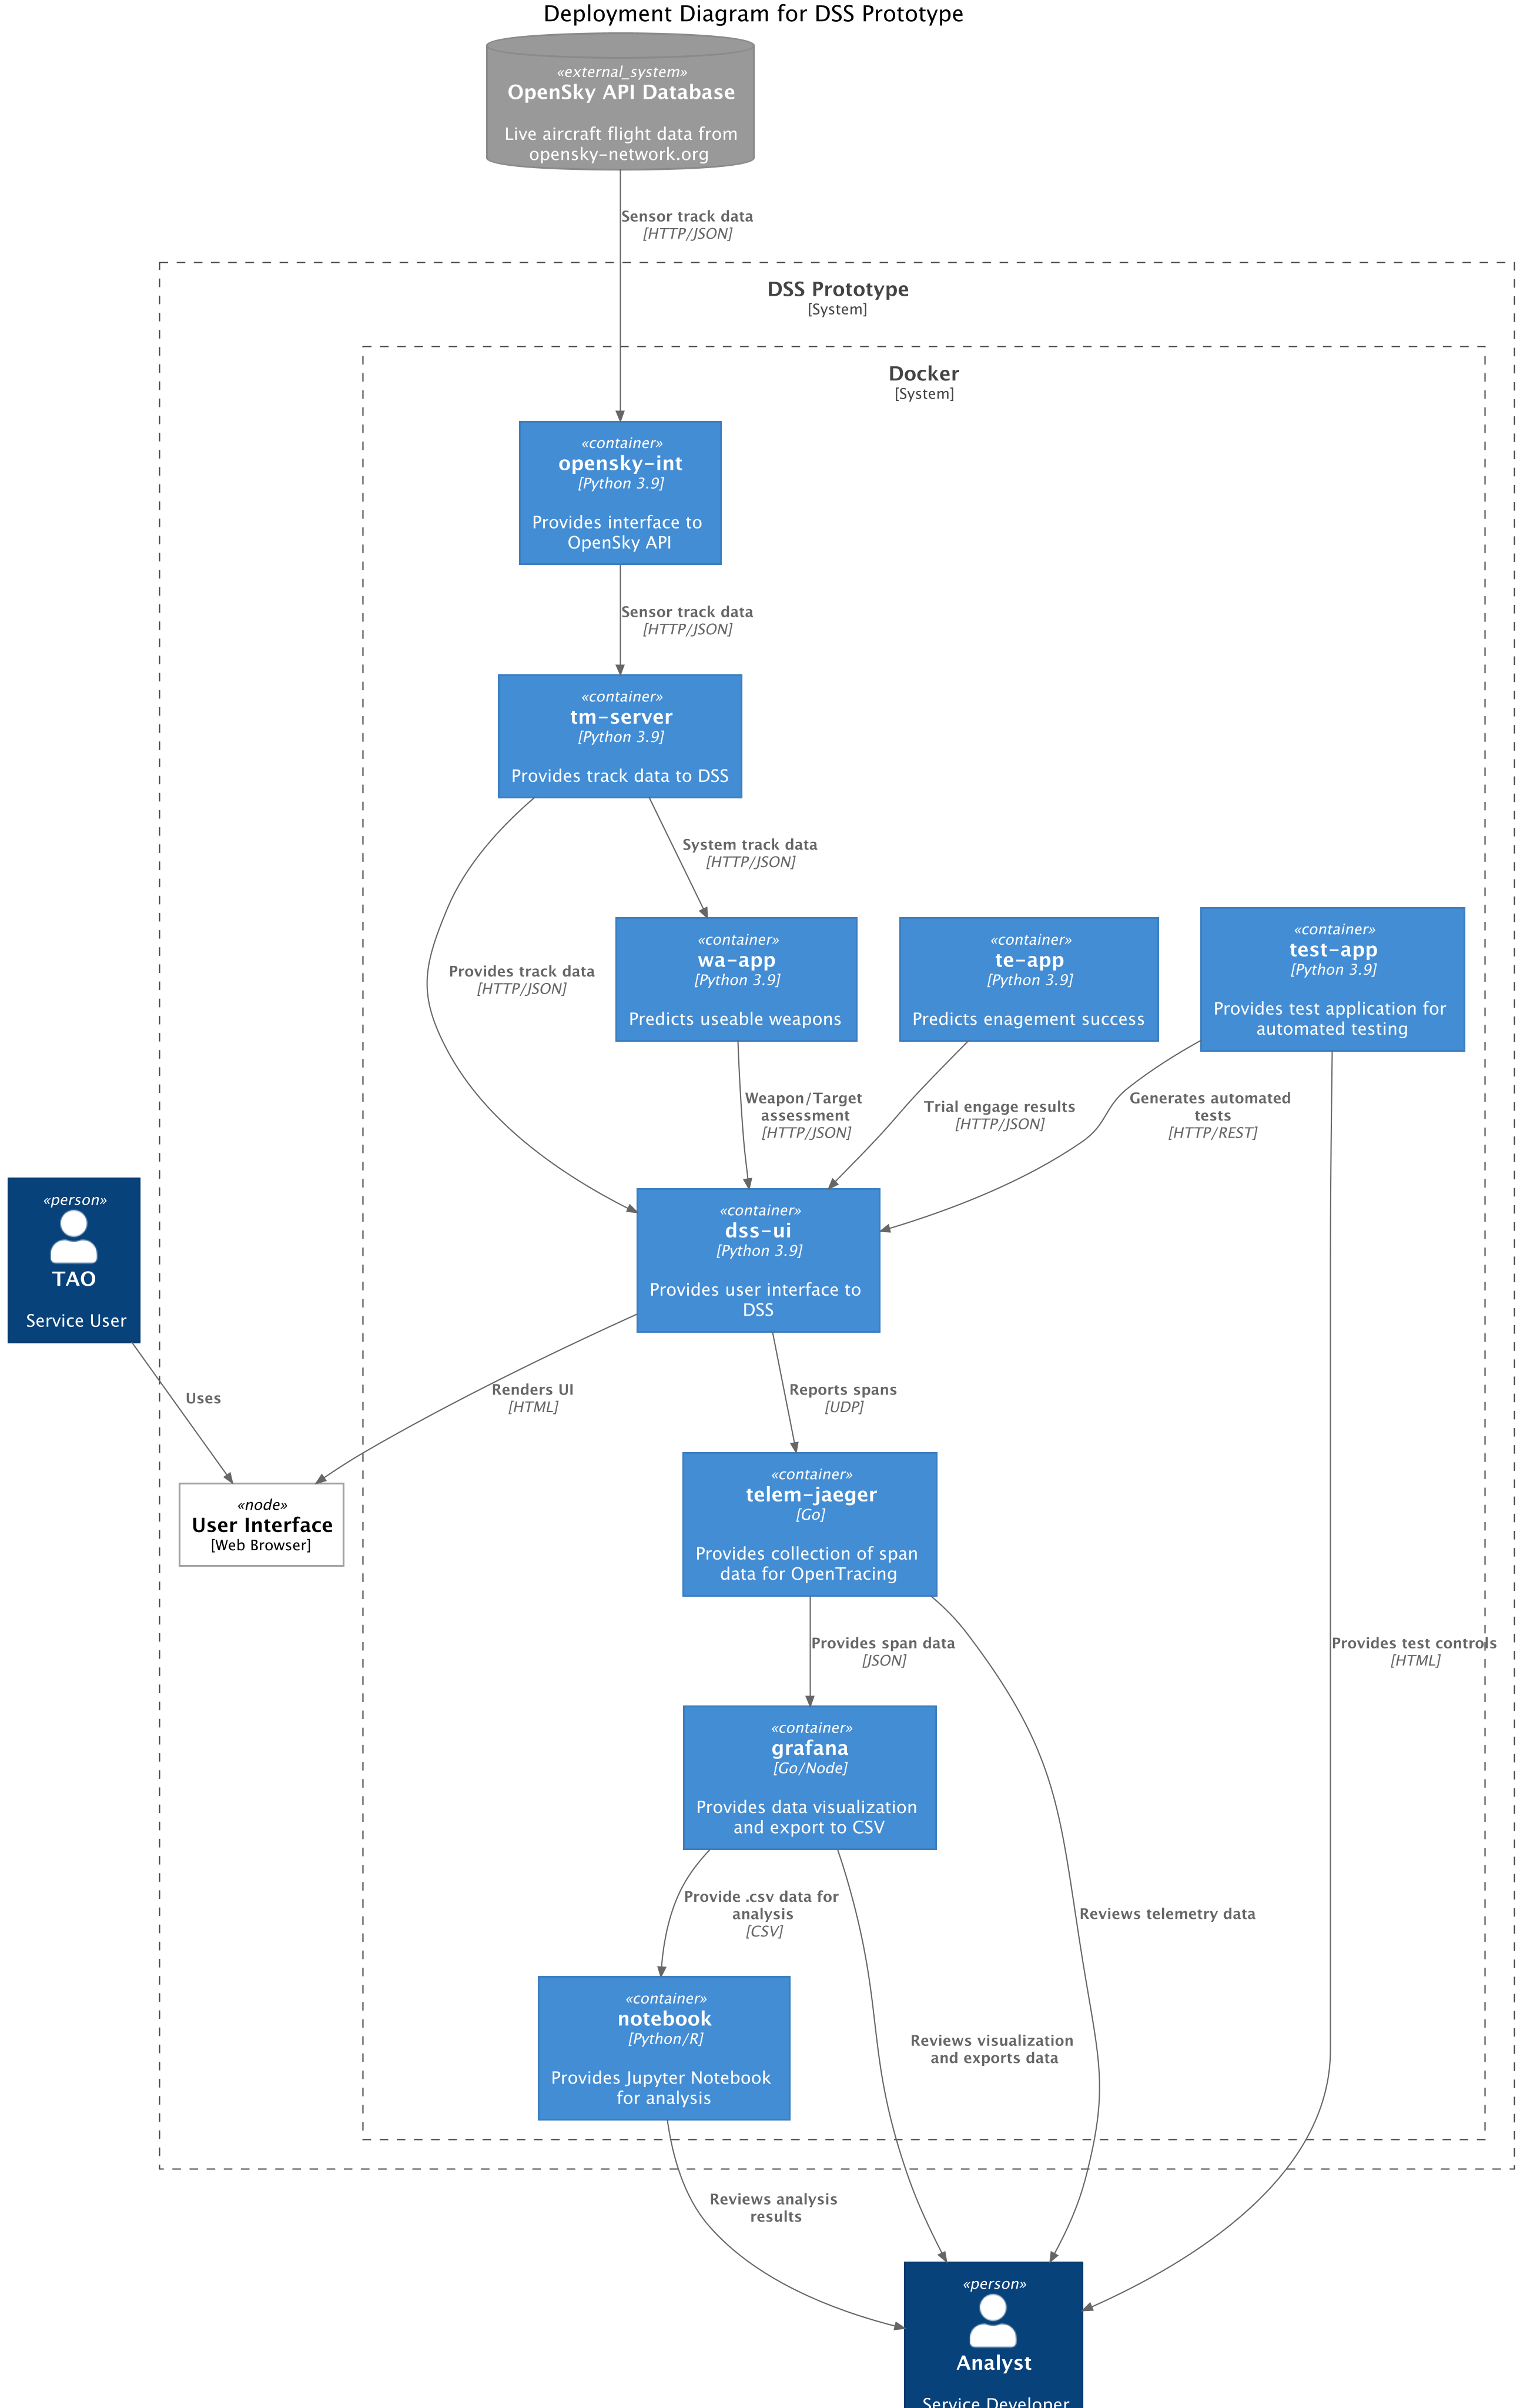

#### Applications ####

- opensky-int: Provides the OpenSky API for flight data. The app provides data about aircraft within 60 NM of Richmond (RIC) or Dulles (IAD) airports.
- tm-server: Provides sensor track data (e.g. OpenSky) and system tracks to support DSS services. System tracks represent the system-wide common understanding of track object states used for decision support.
- wa-app: The Weapon Assessment Application determines which weapons are capable to successfully engage a target. The wa-app uses the tm-server api to get track data.
- te-app: The Trail Engage Application predicts the success probability of an engagement with a specific weapon target pairing. The predicted track kinematic data at engagement time is provided; therefore, the current track kinematics from the tm-server are not queried prior to providing a response.
- test-app: Provides an ability to initiate automated tests. the test-app uses the dss-ui to call dss-ui endpoint to replicate operator interactions with the DSS Prototype.
- dss-ui: Provides a simple graphical interface to launch DSS services.

#### Tools ####

- telem-jaeger: The open source Jaeger containter collects "span" data from the DSS applications. Spans collect duration data for service calls amongst containers; e.g. latency. This the fundamental data that is being analysed here.
- grafana: The open source Grafana container connects to the telem-jaeger container to create visualization dashboards. Also, Grafana faciliates the export of data as a .csv file for analysis.
- notebook: The Jupyter Notebook container supports analysis of the data recorded by Jaeger and exported by Grafana. An embedded R software library is used for analysis.

<!-- 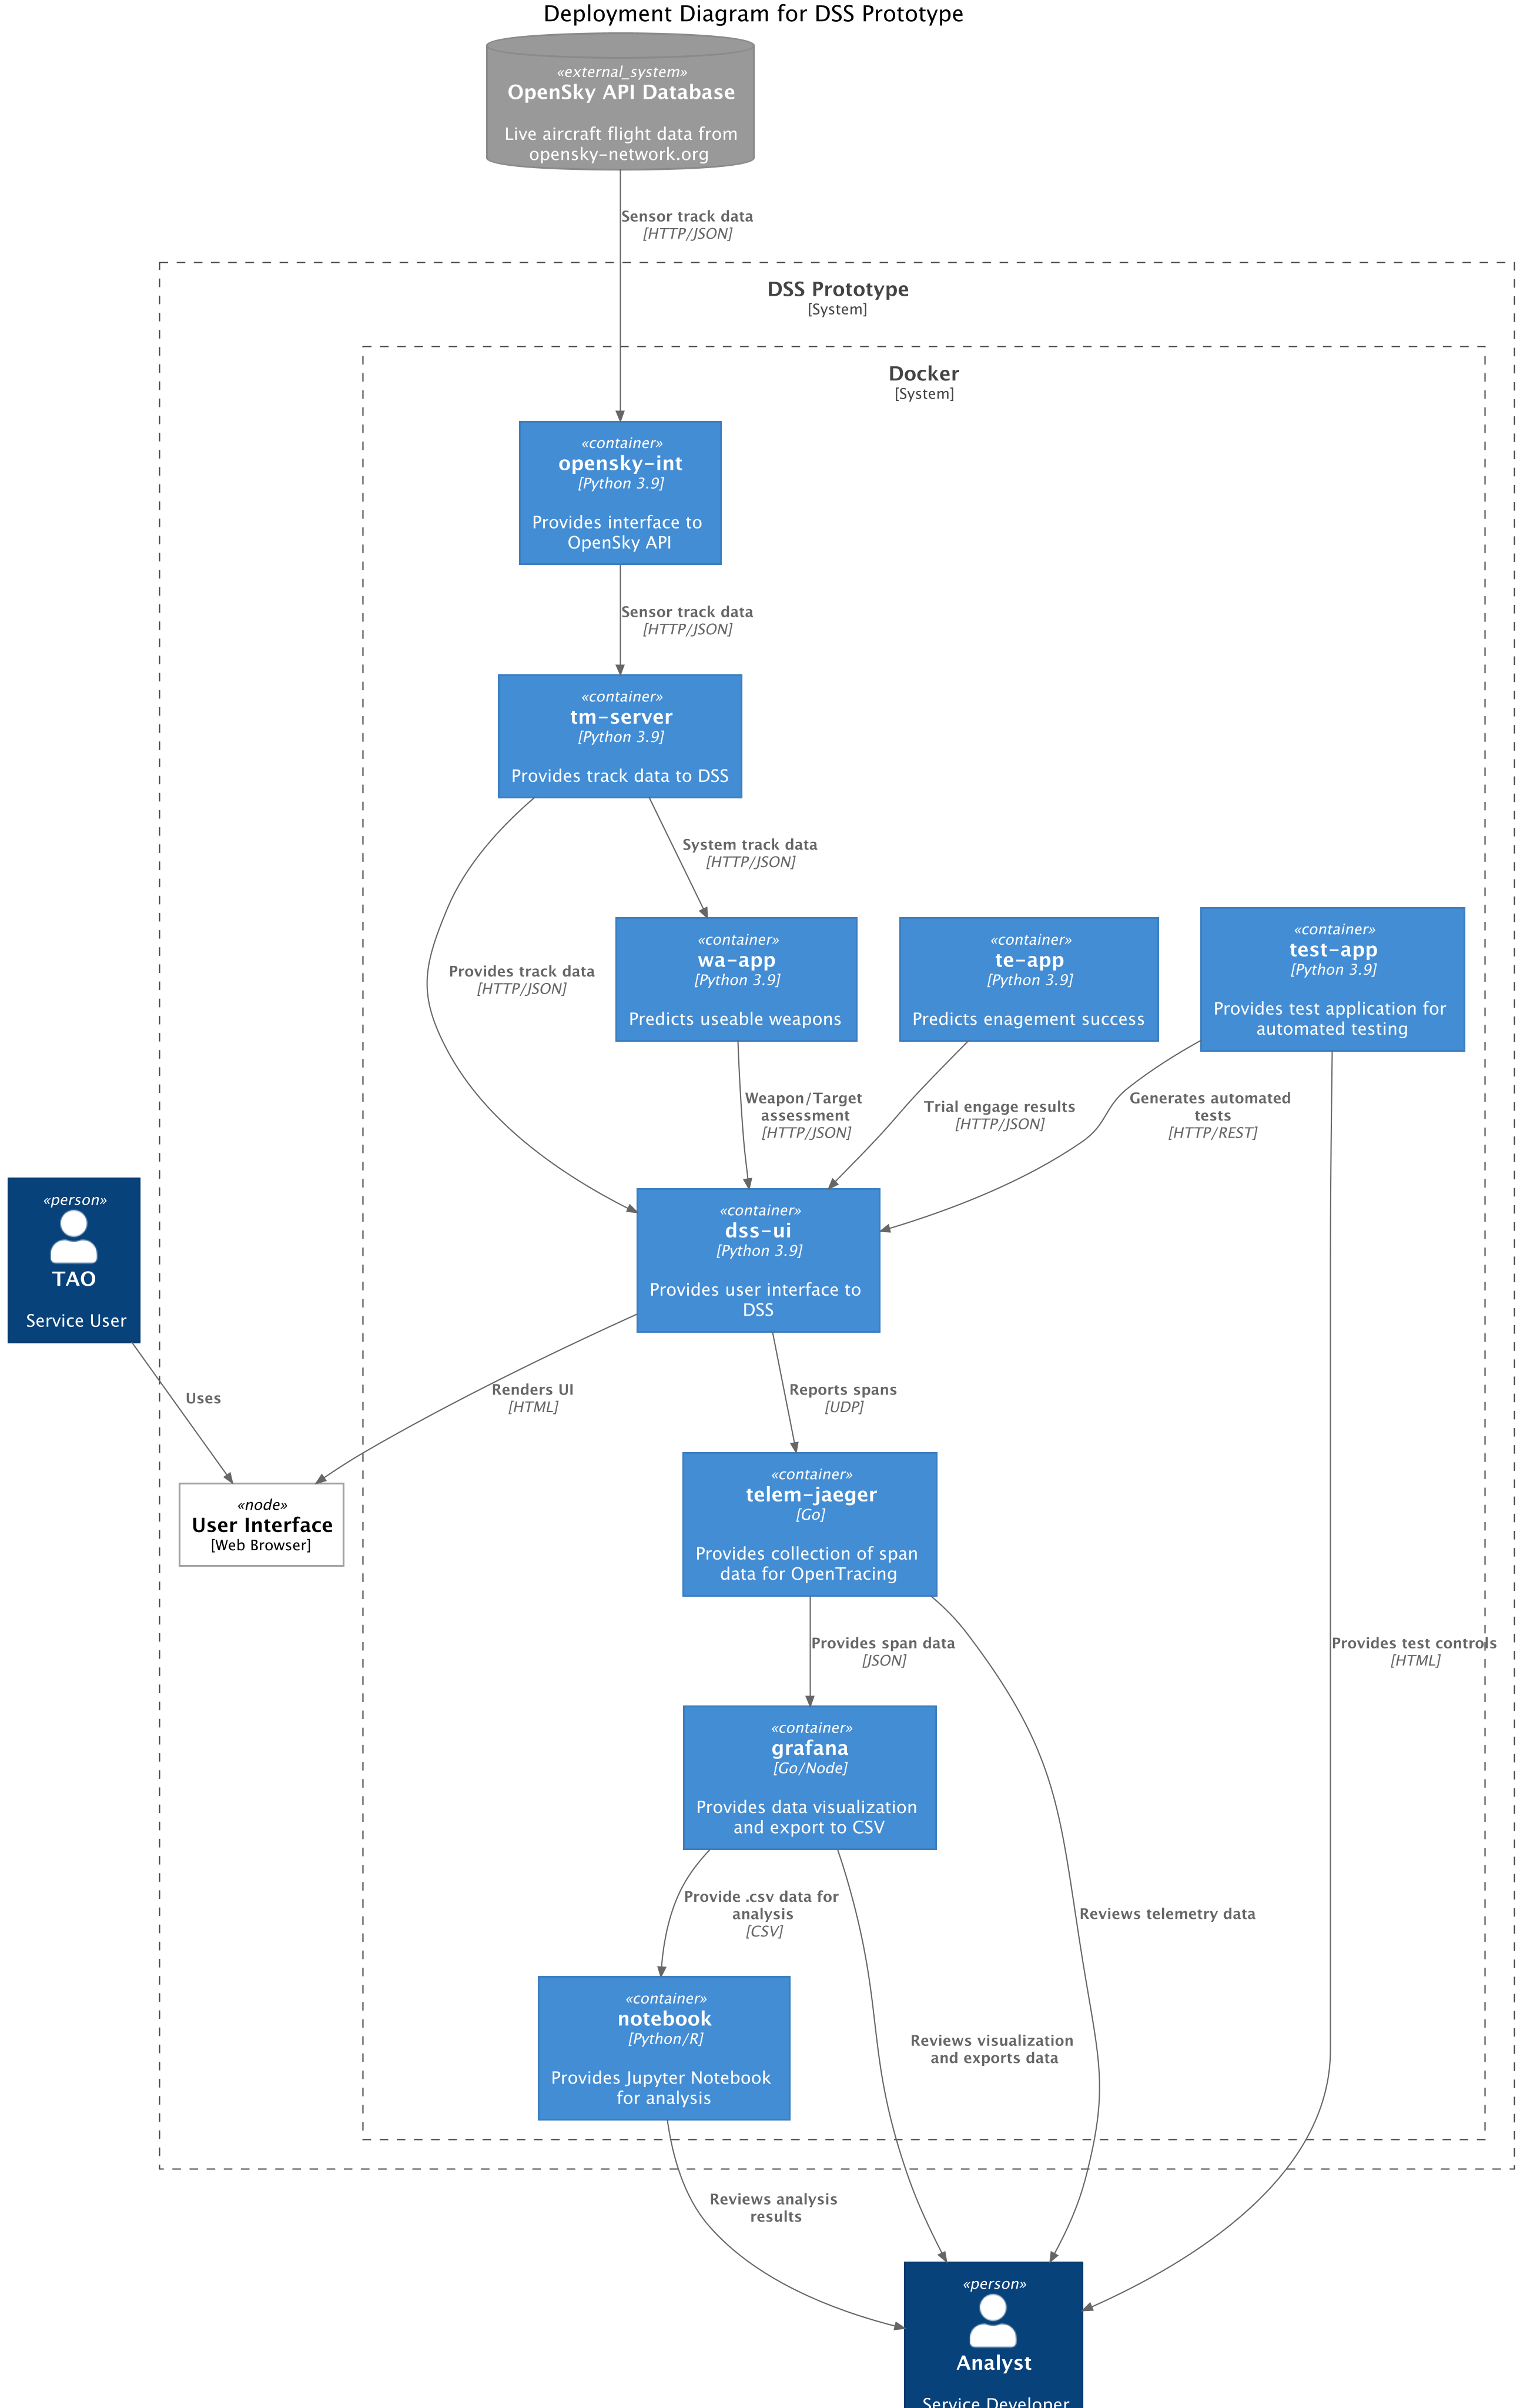 -->

### Hypothesis ###

Hypotheses are "innocent until proven guilty." We'll assume that SpaceX and others have proven that DevSecOps tech can meet hard-real-time requirements but nothing available in the body of knowledge documents this.

**Hypothesis:** Modern DevSecOps architectures can be designed to meet hard-real-time latency ($\mu$) requirements using modern computing environments and computing infrastructure.

$H_0: \mu \le 500  ms$ with jitter within latency bounds   
$H_a: \mu > 500  ms$ with jitter exceeding latency bounds  


_Murphy, Alvin C. and Moreland Jr, James D. ‘Integrating AI Microservices into Hard-Real-Time SoS to Ensure Trustworthiness of Digital Enterprise Using Mission Engineering’. 1 Jan. 2021 : 38 – 54._

In [1]:
install.packages("stringr")                # Install packages and libraries in R
library("stringr", quietly = T)                       

install.packages("dplyr")
library("dplyr", quietly = T)

install.packages("ggplot2") 
install.packages("GGally")
library("ggplot2", quietly = T)                     
library("GGally", quietly = T)

# Note that loading MASS will cause issues with dplyr select
library("MASS")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [2]:
install.packages("mclust")
library(mclust)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Package 'mclust' version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



Scrucca L., Fop M., Murphy T. B. and Raftery A. E. (2016) mclust 5:
clustering, classification and density estimation using Gaussian
finite mixture models The R Journal 8/1, pp. 289-317

In [3]:
options(warn=-1)

In [4]:
setwd('/home/jovyan/work/data')

## Load Data Files ##

In [5]:
macData <- read.csv('DSS_SpanData-mac-2022-05-02 18_38_26_s10-5-1.csv', header = TRUE)
linpcData <- read.csv('DSS_SpanData-linuxpc-2022-06-06 17_38_29_s10-5-1.csv', header = TRUE)
rpi4Data <- read.csv('DSS_SpanData-rpi4-2022-06-06 17_52_59_s10-5-1.csv', header = TRUE)
awsEC2Data <- read.csv('DSS_SpanData-aws_ec2-2022-06-07 17_44_08_s10-5-1.csv', header = TRUE)
cci_Data <- read.csv('DSS_SpanData-odu_cci-2022-06-28 17_47_20_s10-5-1.csv', header = TRUE)

### Review and Tag MacBook Air (2017) Data ###

In [6]:
summary(macData)

   Trace.ID          Trace.name         Start.time          Duration        
 Length:100         Length:100         Length:100         Length:100        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

In [7]:
head(macData[, c(1,2)])
head(macData[, c(3,4)])

,Trace.ID,Trace.name
,<chr>,<chr>
1,9ee3577fb1b427bc4fc17fecc5154d7d,dss-prototype: /TE
2,f05ddc4dc13aff5c3098011b2a402401,dss-prototype: /tracks
3,2bd901fbbfc9ee8dfa7c9629d93a1567,dss-prototype: /IAD
4,69a48381a14e79da08aaa2353f7db4b2,dss-prototype: /RIC
5,e83037dcb9438c04dc12fba373b5502f,dss-prototype: /WA
6,7e381cd880adb670bb9627ca47020938,dss-prototype: /TE


,Start.time,Duration
,<chr>,<chr>
1,2022-05-02 10:25:01.366,36.0 ms
2,2022-05-02 10:25:00.309,43.3 ms
3,2022-05-02 10:24:58.818,464 ms
4,2022-05-02 10:24:57.307,494 ms
5,2022-05-02 10:24:56.128,139 ms
6,2022-05-02 10:24:55.081,30.3 ms


#### Add Source Indicator to MacBook Data ####

In [8]:
macDataPlat <- macData

macDataPlat$platform = "2017-macbook"
macDataPlat$env = 0

### Tag Linux PC (2012) Data ###

In [9]:
linpcDataPlat <- linpcData

linpcDataPlat$platform = "2012-linpc"
linpcDataPlat$env = 1

### Tag Raspberry Pi 4 (2020) Data ###

In [10]:
rpi4DataPlat <- linpcData

rpi4DataPlat$platform = "2020-rpi4"
rpi4DataPlat$env = 2

### Tag AWS EC2 t2.micro Data ###

In [11]:
awsEC2DataPlat <- awsEC2Data

awsEC2DataPlat$platform = "2022-aws-ec2"
awsEC2DataPlat$env = 3

### Tag ODU CCI Data ###

In [12]:
cciDataPlat <- cci_Data

cciDataPlat$platform = "2022-odu-cci"
cciDataPlat$env = 4

### Merge Data Files ###

In [14]:
spanData = rbind(macDataPlat, linpcDataPlat, rpi4DataPlat, awsEC2DataPlat, cciDataPlat)

# summary(spanData)
# head(spanData[, c(1,2,3)])
# head(spanData[, c(4,5,6)])
# spanData

Trace.ID,Trace.name,Start.time,Duration,platform,env
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
9ee3577fb1b427bc4fc17fecc5154d7d,dss-prototype: /TE,2022-05-02 10:25:01.366,36.0 ms,2017-macbook,0
f05ddc4dc13aff5c3098011b2a402401,dss-prototype: /tracks,2022-05-02 10:25:00.309,43.3 ms,2017-macbook,0
2bd901fbbfc9ee8dfa7c9629d93a1567,dss-prototype: /IAD,2022-05-02 10:24:58.818,464 ms,2017-macbook,0
69a48381a14e79da08aaa2353f7db4b2,dss-prototype: /RIC,2022-05-02 10:24:57.307,494 ms,2017-macbook,0
e83037dcb9438c04dc12fba373b5502f,dss-prototype: /WA,2022-05-02 10:24:56.128,139 ms,2017-macbook,0
7e381cd880adb670bb9627ca47020938,dss-prototype: /TE,2022-05-02 10:24:55.081,30.3 ms,2017-macbook,0
092e01448c8f39b99d39c60c456cda72,dss-prototype: /tracks,2022-05-02 10:24:54.040,30.0 ms,2017-macbook,0
55f2710ea10d84caf8ba9e5bf31ce7f9,dss-prototype: /IAD,2022-05-02 10:24:52.545,478 ms,2017-macbook,0
d1a0499b11129a50393aaa1f6e478cfc,dss-prototype: /RIC,2022-05-02 10:24:50.974,546 ms,2017-macbook,0


## Convert Data into Useable Metrics ##

To make the data more usable and easier to understand we apply conversions from text to numeric and add additional columns with supporting information. A **useCase** column is added to identify specific DSS request use cases; e.g. Get Dulles Airport Data. The data also indicates whether the request is managed internally or a connection to an external service is required to provided a response (i.e., https://opensky-network.org).  A **numContainers** column is added to indicate the number of containers involved in providing a use case response (e.g. independent variable). An **ext** column is added to indicate whether an API external to the Docker environment is used; e.g., ext = TRUE for OpenSky API calls.

In [15]:
## Dictionary for converting data

DSSoperations <- c(
    "dss-prototype: /IAD" = "Get Dulles Airport Data (External)",
    "dss-prototype: /RIC" = "Get Richmond Airport Data (External)",
    "dss-prototype: /tracks" = "Get Stored Local DSS Tracks (Internal)",
    "dss-prototype: /TE" = "Trial Engage (Internal)",
    "dss-prototype: /WA" = "Assess Weapons (Internal)"
)

DSSuseCaseNum <- c(
    "dss-prototype: /IAD" = 4,
    "dss-prototype: /RIC" = 5,
    "dss-prototype: /tracks" = 1,
    "dss-prototype: /TE" = 2,
    "dss-prototype: /WA" = 3
)

DSSexternal <- c(
    "dss-prototype: /IAD" = TRUE,
    "dss-prototype: /RIC" = TRUE,
    "dss-prototype: /tracks" = FALSE,
    "dss-prototype: /TE" = FALSE,
    "dss-prototype: /WA" = FALSE
)

DSStraceShortName <- c(
    "dss-prototype: /IAD" = "/IAD",
    "dss-prototype: /RIC" = "/RIC",
    "dss-prototype: /tracks" = "/tracks",
    "dss-prototype: /TE" = "/TE",
    "dss-prototype: /WA" = "/WA"
)

### Add Additional Column Descriptors ###

In [77]:
spanMetrics <- spanData

In [78]:
spanMetrics$useCase <- DSSoperations[spanMetrics$Trace.name]
spanMetrics$useCaseNum <- DSSuseCaseNum[spanMetrics$Trace.name]

spanMetrics$ext = DSSexternal[spanMetrics$Trace.name]
spanMetrics$Trace.name = DSStraceShortName[spanMetrics$Trace.name]
    
# truncate span ID
# spanMetrics$Trace.ID <- str_sub(spanMetrics$Trace.ID,1,4)
    

# summary(spanMetrics)
# head(spanMetrics)
# tail(spanMetrics)

# spanMetrics

In [79]:
# Convert character data into numeric metrics

for(index in 1:nrow(spanMetrics)) {       # for-loop over rows
    
    # Convert span duration
    
    char = spanMetrics[index,4]
    len = str_length(char)
    duration = str_sub(char,1,(len-3))
    units = str_sub(char,(len-1),len)
    duration = as.numeric(duration)
    
    # print(duration)
    # print(units)

    if(units == 'ms') {
        duration = duration               # Keep ms
    } else if (units == 'µs') {
        duration = duration * 0.001       # Convert µs to ms
    } else if (units == ' s') {
        duration = duration * 1000        # Convert s to ms
    } else {
        print ('Unable to find specified units')
        print (units)
    }
    spanMetrics[index,4] = duration
    
    # Convert time

    # time = spanMetrics[index,3]
    # epoch <- as.POSIXct(time)
    # epoch_int <- as.integer(epoch)
    # spanMetrics[index,3] = epoch_int
}

# spanMetrics

In [80]:
# Convert columns from char to numeric

spanMetrics$Duration = as.numeric(spanMetrics$Duration)
# spanMetrics$Start.time = as.numeric(spanMetrics$Start.time)

# spanMetrics

Trace.ID,Trace.name,Start.time,Duration,platform,env,useCase,useCaseNum,ext
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<lgl>
9ee3577fb1b427bc4fc17fecc5154d7d,/TE,2022-05-02 10:25:01.366,36.0,2017-macbook,0,Trial Engage (Internal),2,FALSE
f05ddc4dc13aff5c3098011b2a402401,/tracks,2022-05-02 10:25:00.309,43.3,2017-macbook,0,Get Stored Local DSS Tracks (Internal),1,FALSE
2bd901fbbfc9ee8dfa7c9629d93a1567,/IAD,2022-05-02 10:24:58.818,464.0,2017-macbook,0,Get Dulles Airport Data (External),4,TRUE
69a48381a14e79da08aaa2353f7db4b2,/RIC,2022-05-02 10:24:57.307,494.0,2017-macbook,0,Get Richmond Airport Data (External),5,TRUE
e83037dcb9438c04dc12fba373b5502f,/WA,2022-05-02 10:24:56.128,139.0,2017-macbook,0,Assess Weapons (Internal),3,FALSE
7e381cd880adb670bb9627ca47020938,/TE,2022-05-02 10:24:55.081,30.3,2017-macbook,0,Trial Engage (Internal),2,FALSE
092e01448c8f39b99d39c60c456cda72,/tracks,2022-05-02 10:24:54.040,30.0,2017-macbook,0,Get Stored Local DSS Tracks (Internal),1,FALSE
55f2710ea10d84caf8ba9e5bf31ce7f9,/IAD,2022-05-02 10:24:52.545,478.0,2017-macbook,0,Get Dulles Airport Data (External),4,TRUE
d1a0499b11129a50393aaa1f6e478cfc,/RIC,2022-05-02 10:24:50.974,546.0,2017-macbook,0,Get Richmond Airport Data (External),5,TRUE


In [83]:
summary(spanMetrics)

spanMetricsA <- arrange(spanMetrics, useCaseNum)

head(spanMetricsA[, c(1,2,3,4,5)])
head(spanMetricsA[, c(6,7,8,9)])

# spanMetricsA

   Trace.ID          Trace.name         Start.time           Duration      
 Length:500         Length:500         Length:500         Min.   :   4.29  
 Class :character   Class :character   Class :character   1st Qu.:   7.42  
 Mode  :character   Mode  :character   Mode  :character   Median :  21.65  
                                                          Mean   : 198.15  
                                                          3rd Qu.: 381.00  
                                                          Max.   :2000.00  
   platform              env      useCase            useCaseNum    ext         
 Length:500         Min.   :0   Length:500         Min.   :1    Mode :logical  
 Class :character   1st Qu.:1   Class :character   1st Qu.:2    FALSE:300      
 Mode  :character   Median :2   Mode  :character   Median :3    TRUE :200      
                    Mean   :2                      Mean   :3                   
                    3rd Qu.:3                      3rd Qu.:4        

,Trace.ID,Trace.name,Start.time,Duration,platform
,<chr>,<chr>,<chr>,<dbl>,<chr>
1,f05ddc4dc13aff5c3098011b2a402401,/tracks,2022-05-02 10:25:00.309,43.3,2017-macbook
2,092e01448c8f39b99d39c60c456cda72,/tracks,2022-05-02 10:24:54.040,30.0,2017-macbook
3,002df2c1fe34daa6e39ceb3cb6d20072,/tracks,2022-05-02 10:24:47.706,126.0,2017-macbook
4,8c363c4044084c32e64cb04281f4825a,/tracks,2022-05-02 10:24:41.527,20.5,2017-macbook
5,8b14791720bc81a538a092b431c602bd,/tracks,2022-05-02 10:24:34.903,27.6,2017-macbook
6,15f7e65d2d84a364455179dfb849b31d,/tracks,2022-05-02 10:24:28.865,15.5,2017-macbook


,env,useCase,useCaseNum,ext
,<dbl>,<chr>,<dbl>,<lgl>
1,0,Get Stored Local DSS Tracks (Internal),1,FALSE
2,0,Get Stored Local DSS Tracks (Internal),1,FALSE
3,0,Get Stored Local DSS Tracks (Internal),1,FALSE
4,0,Get Stored Local DSS Tracks (Internal),1,FALSE
5,0,Get Stored Local DSS Tracks (Internal),1,FALSE
6,0,Get Stored Local DSS Tracks (Internal),1,FALSE


### Exploratory Analysis Plots ###

In [138]:
spanMetricsNum <- spanMetricsA %>%
    dplyr::select(useCaseNum, Duration)

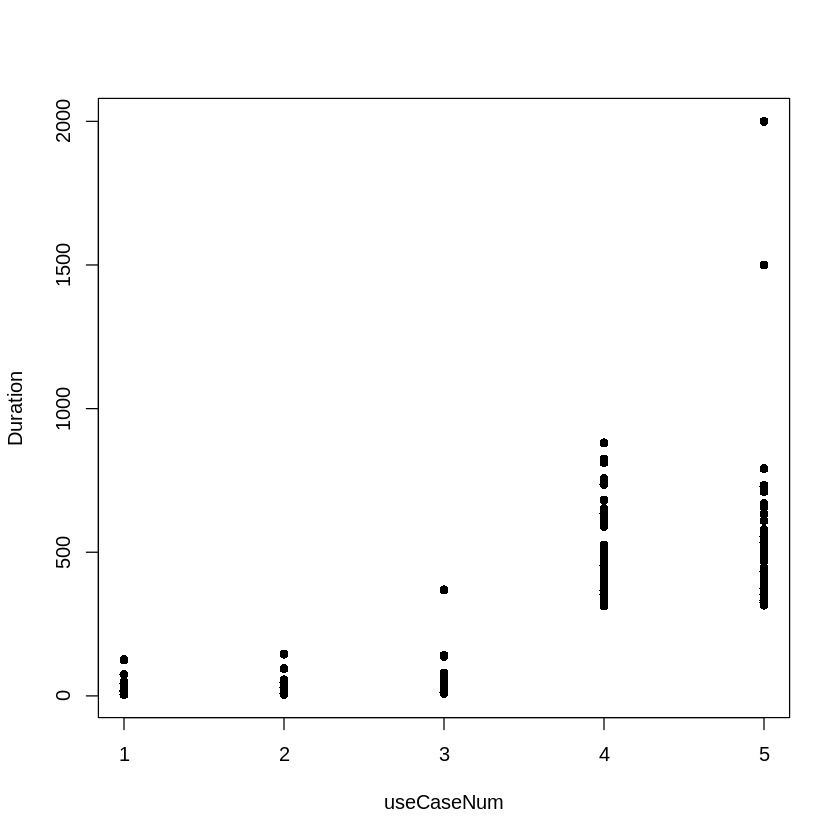

In [139]:
Duration <- spanMetricsNum$Duration
clPairs(spanMetricsNum, Duration) 

#### mclust ####

Used mclust to verify the separation of internal and external models as indicated from the useCaseNum vs. Duration plot; i.e. use cases 4 and 5 use an external API.

The library mclust is a contributed R package for model-based clustering, classification, and density estimation based on finite normal mixture modelling. It provides functions for parameter estimation via the EM algorithm for normal mixture models with a variety of covariance structures, and functions for simulation from these models.


_Scrucca L., Fop M., Murphy T. B. and Raftery A. E. (2016) mclust 5: clustering, classification and density estimation using Gaussian finite mixture models The R Journal 8/1, pp. 289-317_

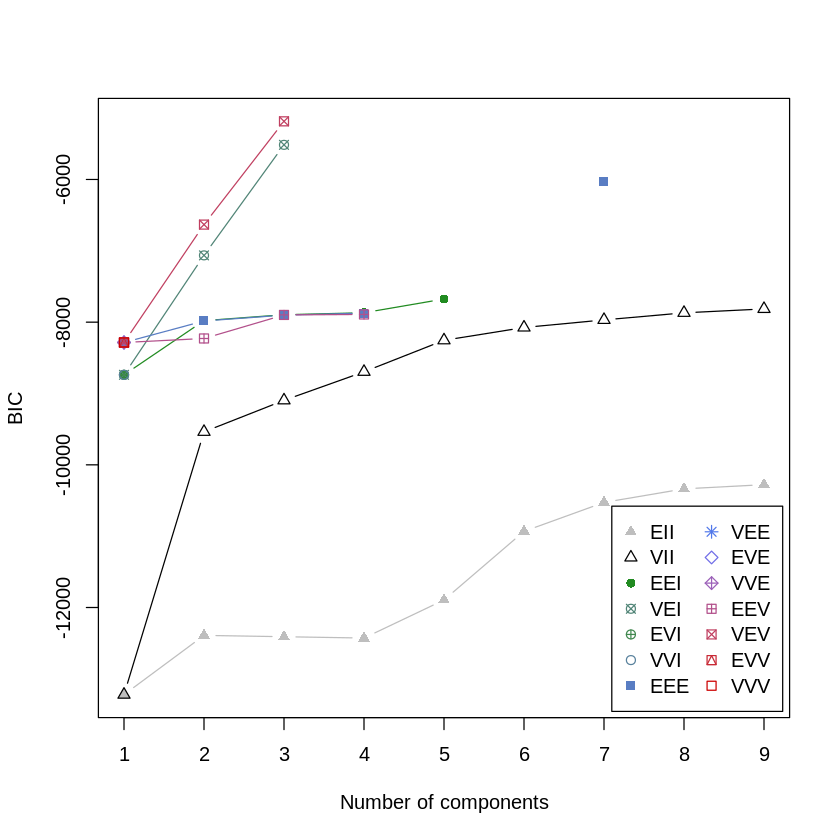

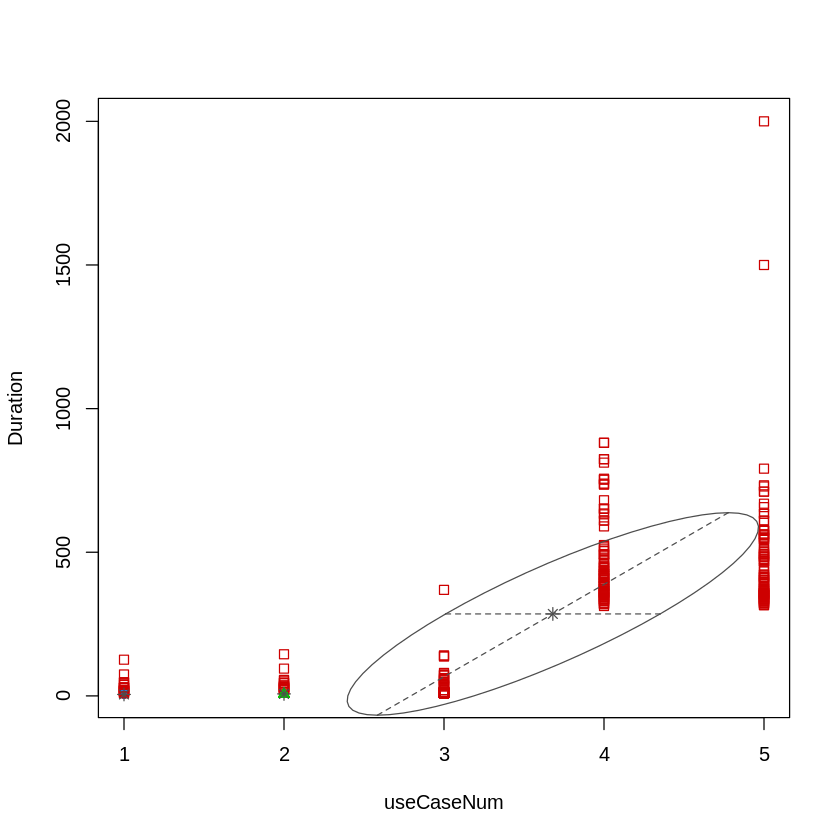

Best BIC values:
             VEV,3      VEI,3      EEE,7
BIC      -5185.134 -5514.7315 -6030.2143
BIC diff     0.000  -329.5976  -845.0805

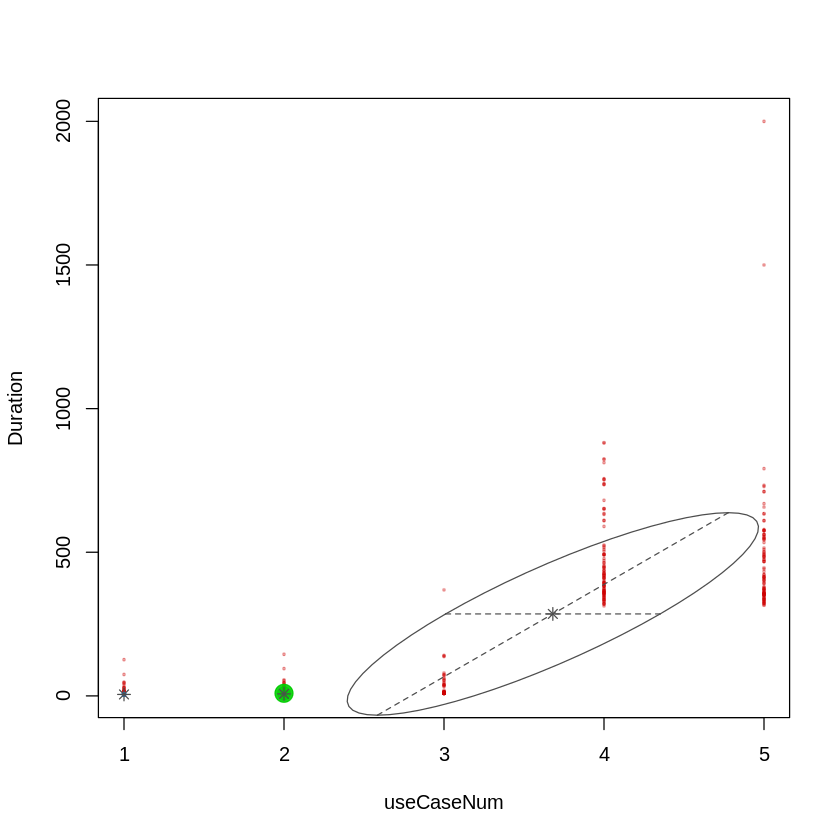

In [140]:
BIC <- mclustBIC(spanMetricsNum)
mod1 <- Mclust(spanMetricsNum, x = BIC)

plot(BIC, what = c("classification"))
plot(mod1, what = c("classification"))
plot(mod1, what = c("uncertainty"))

summary(BIC)

In [141]:
Mclust(spanMetricsNum)

'Mclust' model object: (VEV,3) 

Available components: 
 [1] "call"           "data"           "modelName"      "n"             
 [5] "d"              "G"              "BIC"            "loglik"        
 [9] "df"             "bic"            "icl"            "hypvol"        
[13] "parameters"     "z"              "classification" "uncertainty"   

In [142]:
# summary(BIC)

# mod1 <- Mclust(spanMetricsNum, x = BIC)
# summary(mod1, parameters = TRUE)

In [143]:
# spanMetrics %>%
#     dplyr::select(Duration, useCaseNum, env) %>%
#     ggpairs(spanMetrics)

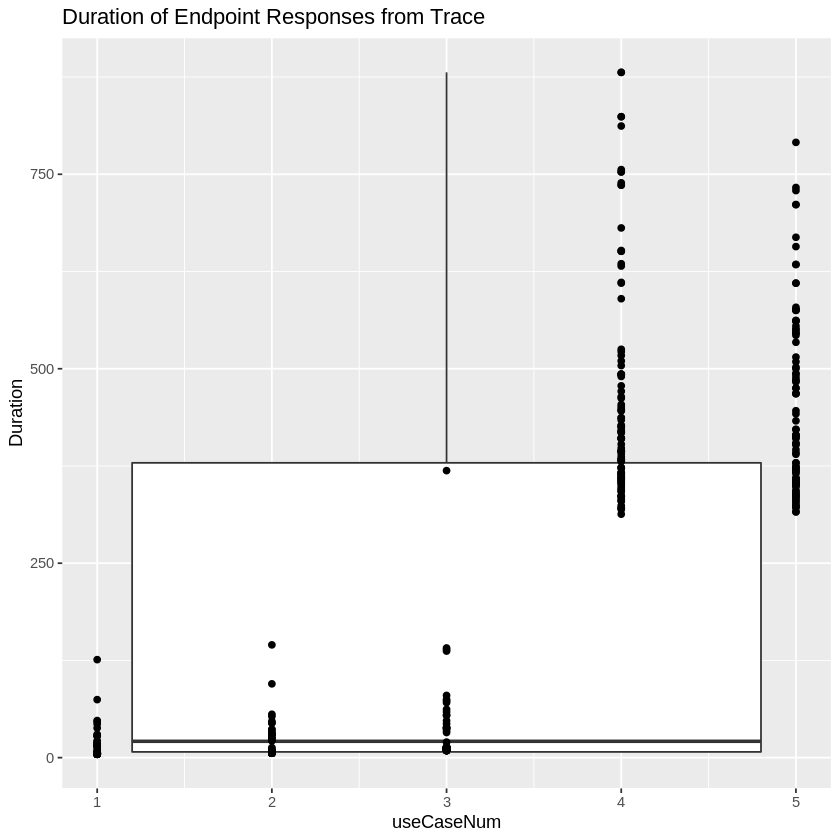

In [151]:
cleanMetrics %>%
    ggplot(aes(useCaseNum, Duration)) + 
    geom_boxplot(notch="FALSE") + geom_point() +
    ggtitle("Duration of Endpoint Responses from Trace")

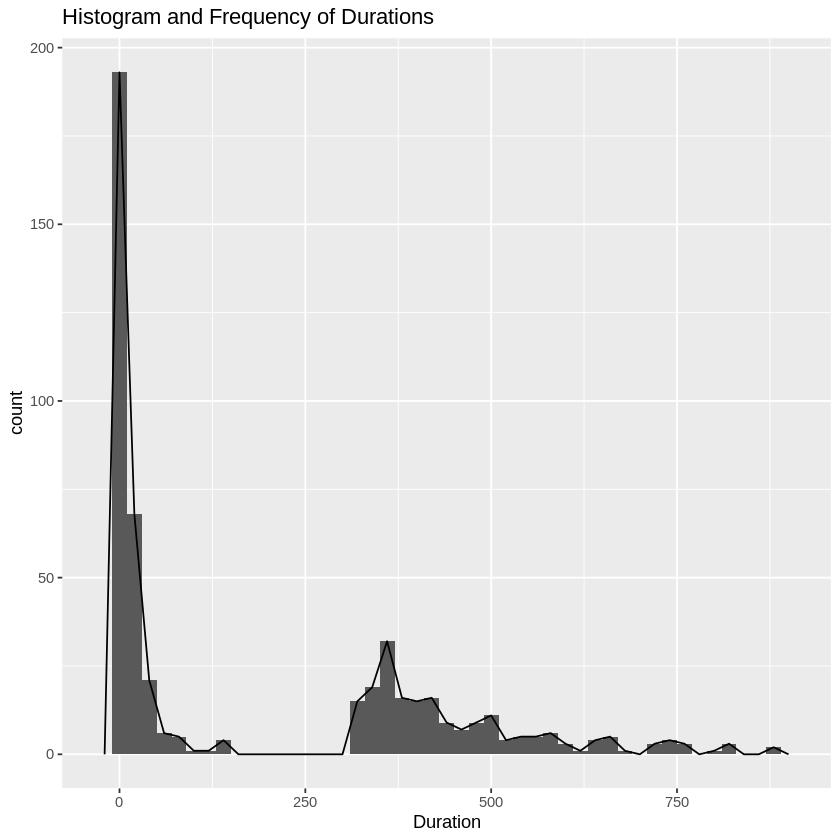

In [149]:
cleanMetrics %>%
    ggplot(aes(Duration)) + 
    geom_histogram(binwidth = 20) + 
    geom_freqpoly(binwidth = 20) +
    ggtitle("Histogram and Frequency of Durations")

### Q-Q Normality Test ###

ERROR while rich displaying an object: Error in factor(useCase): object 'useCase' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.output(print(

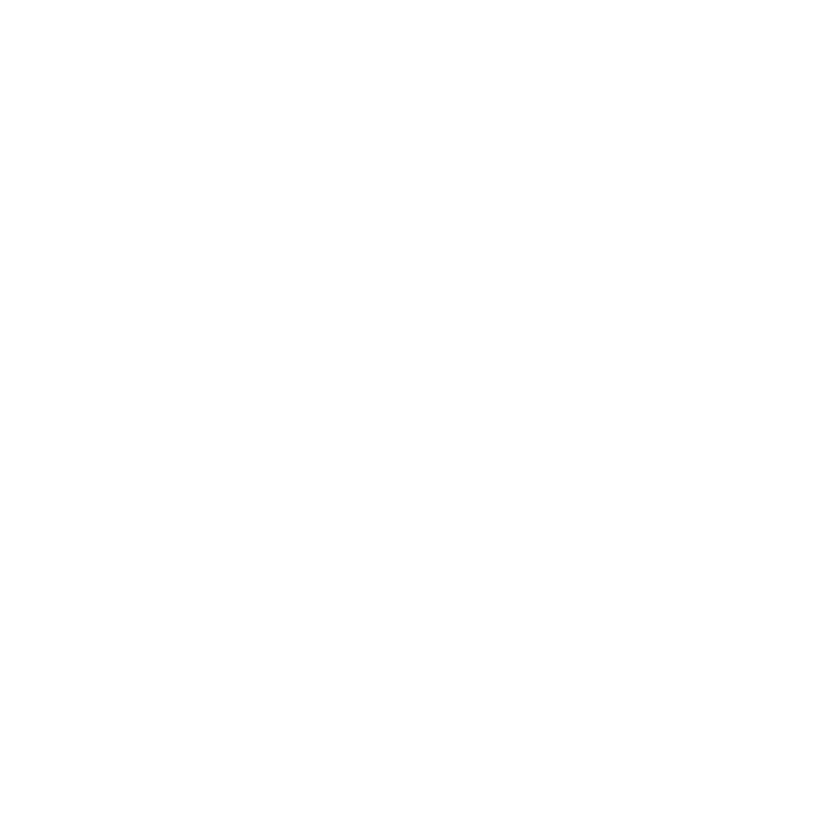

In [152]:
# qqnorm(spanMetrics$Duration,main="Span Duration Q-Q Norm Plot")
# qqline(spanMetrics$Duration)

cleanMetrics %>%
    ggplot(aes(sample = Duration, colour = factor(useCase), shape = factor(env))) +
    stat_qq() +
    stat_qq_line() +
    labs(title="Q-Q Plot of Duration",
       x = "Theoretical Quantiles", y = "Sample Quantiles")

In [127]:
shapiro.test(spanMetricsA$Duration)


	Shapiro-Wilk normality test

data:  spanMetricsA$Duration
W = 0.7464, p-value < 2.2e-16


A transformation is needed to apply statistical analysis.

In [95]:
# par(mfrow=c(1,2))
# hist(cleanMetrics$Duration)
# boxplot(cleanMetrics$Duration~cleanMetrics$Trace.name)
# boxplot(cleanMetrics$Duration~cleanMetrics$Trace.name, notch=TRUE)

# cleanMetrics %>%
#     ggplot(aes(sample = Duration, colour = factor(useCase), shape = factor(env))) +
#     stat_qq() +
#     stat_qq_line() +
#     labs(title="Q-Q Plot of Duration",
#        x = "Theoretical Quantiles", y = "Sample Quantiles")

In [96]:
# cleanMetrics %>%
#     ggplot(aes(Trace.name, Duration, notch=TRUE)) + 
#     geom_boxplot() + geom_point() +
#     ggtitle("Duration of Endpoint Responses from 'useCase'")

In [97]:
# cleanMetricsNum <- cleanMetrics %>%
    # dplyr::select(Duration, useCaseNum, ext, env)

In [98]:
# Duration <- cleanMetricsNum$Duration
# clPairs(cleanMetricsNum, Duration)

### Normality Testing of Each Environment ###

In [99]:
env0MacSubset = subset(cleanMetrics, env == 0)
shapiro.test(env0MacSubset$Duration)
env1LinSubset = subset(cleanMetrics, env == 1)
shapiro.test(env1LinSubset$Duration)
env2PiSubset = subset(cleanMetrics, env == 2)
shapiro.test(env2PiSubset$Duration)
env3AWSSubset = subset(cleanMetrics, env == 3)
shapiro.test(env3AWSSubset$Duration)
env4CCI_Subset = subset(cleanMetrics, env == 4)
shapiro.test(env4CCI_Subset$Duration)


	Shapiro-Wilk normality test

data:  env0MacSubset$Duration
W = 0.78089, p-value = 7.724e-11



	Shapiro-Wilk normality test

data:  env1LinSubset$Duration
W = 0.74353, p-value = 6.337e-12



	Shapiro-Wilk normality test

data:  env2PiSubset$Duration
W = 0.74353, p-value = 6.337e-12



	Shapiro-Wilk normality test

data:  env3AWSSubset$Duration
W = 0.73428, p-value = 3.67e-12



	Shapiro-Wilk normality test

data:  env4CCI_Subset$Duration
W = 0.74182, p-value = 6.676e-12


### Transformation of Clean Metrics ###

#### Sqrt, Log, and Cube Transformations ####

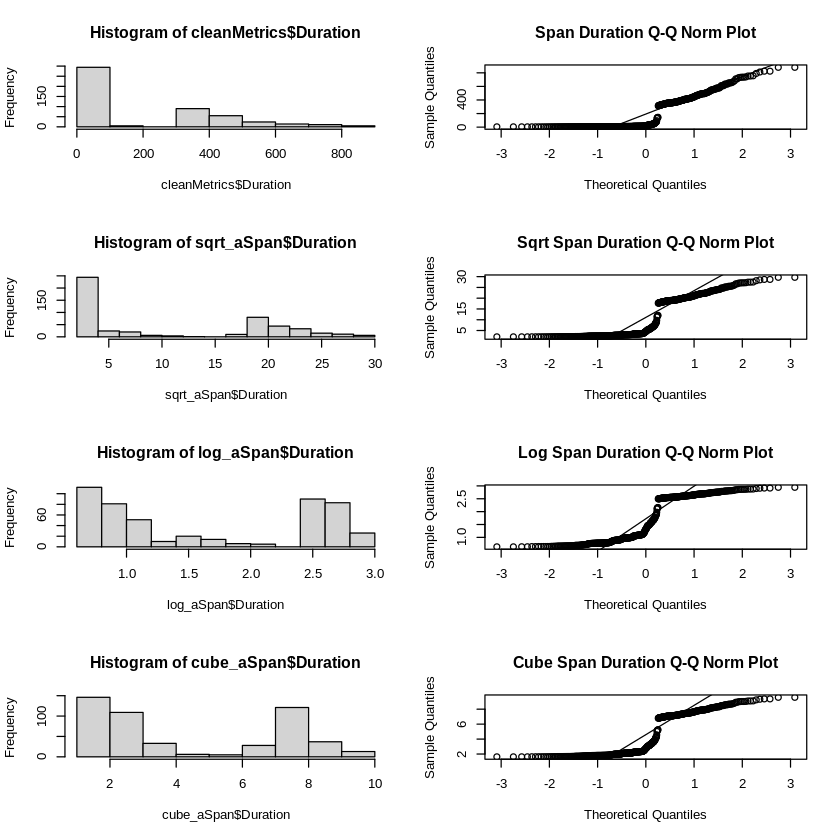

In [100]:
sqrt_aSpan <- cleanMetrics
sqrt_aSpan$Duration=sqrt(sqrt_aSpan$Duration)
log_aSpan <- cleanMetrics
log_aSpan$Duration=log10(log_aSpan$Duration)
cube_aSpan <- cleanMetrics
cube_aSpan$Duration=cube_aSpan$Duration^(1/3)

par(mfrow=c(4,2))
hist(cleanMetrics$Duration)
qqnorm(cleanMetrics$Duration,main="Span Duration Q-Q Norm Plot")
qqline(cleanMetrics$Duration)
hist(sqrt_aSpan$Duration)
qqnorm(sqrt_aSpan$Duration,main="Sqrt Span Duration Q-Q Norm Plot")
qqline(sqrt_aSpan$Duration)
hist(log_aSpan$Duration)
qqnorm(log_aSpan$Duration,main="Log Span Duration Q-Q Norm Plot")
qqline(log_aSpan$Duration)
hist(cube_aSpan$Duration)
qqnorm(cube_aSpan$Duration,main="Cube Span Duration Q-Q Norm Plot")
qqline(cube_aSpan$Duration)

None of these transformation yield distributions that would be considered normal. Most likely due to access to external and internal services with differing latency. Lets try another transformation. 

Our assumption here is that the separation of **Sample Quantiles** is from the difference between internal and external span durations (e.g. latency). Let's see what happens when we split the samples.

## Separating "Clean" Internal from External Data ##

### Internal Data ###

In [101]:
# Could use ext == FALSE

tracksSpanData = subset(cleanMetrics, Trace.name == "/tracks")
TE_SpanData = subset(cleanMetrics, Trace.name == "/TE")
WA_SpanData = subset(cleanMetrics, Trace.name == "/WA")

internalSpanData <- rbind(tracksSpanData, TE_SpanData, WA_SpanData)
dssSpanData <- rbind(TE_SpanData, WA_SpanData)

# head(tracksSpanData)
# head(TE_SpanData)
# head(WA_SpanData)
# head(internalSpanData)

# par(mfrow=c(2,2))
# hist(internalSpanData$Duration)
# boxplot(internalSpanData$Duration~internalSpanData$Trace.name)
# hist(dssSpanData$Duration)
# boxplot(dssSpanData$Duration~dssSpanData$Trace.name)

In [102]:
outliers <- boxplot(internalSpanData$Duration, plot = FALSE)$out
outliers

iSpan <- internalSpanData
iSpan <- iSpan[-which(iSpan$Duration %in% outliers),]

[1]  43.3  30.0 126.0  27.6  28.5  74.6  38.1  46.5  28.3  47.7  36.0  30.3
[13]  24.5  36.5  30.1  46.7  29.4  94.9  26.2  23.9  55.8  32.9  44.8 145.0
[25]  44.3  53.1  30.5  29.2 139.0  70.7  74.8 369.0  80.0  38.6  54.6  62.1
[37]  43.5  39.0  54.3  47.5  37.7 137.0  72.9  32.3  58.8 141.0  35.1  37.5


	Shapiro-Wilk normality test

data:  internalSpanData$Duration
W = 0.38727, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  dssSpanData$Duration
W = 0.38853, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  iSpan$Duration
W = 0.86794, p-value = 6.384e-14


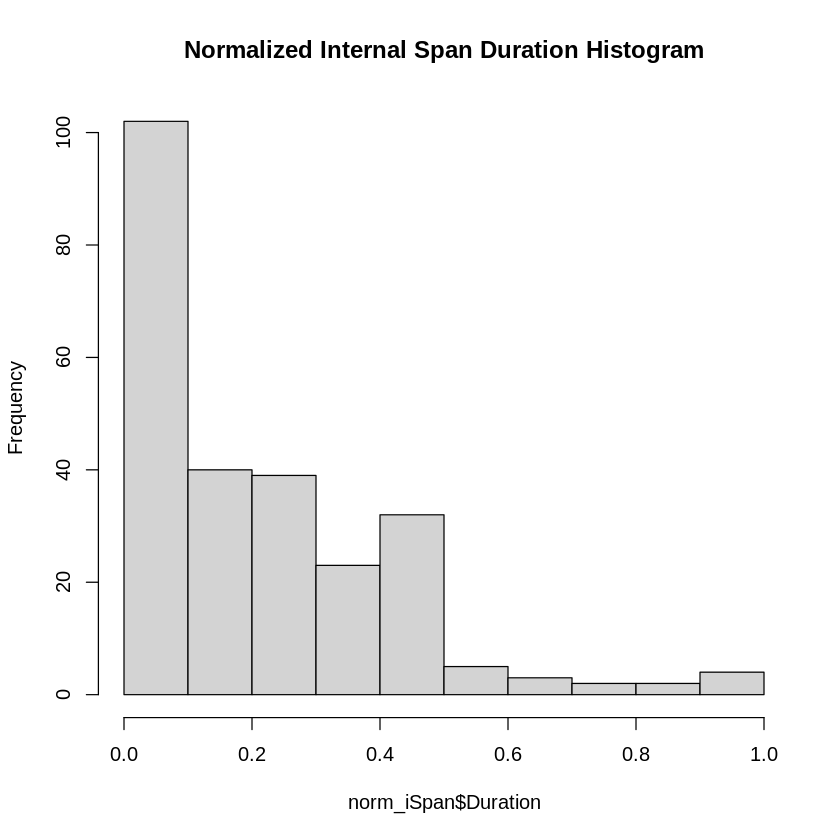


	Shapiro-Wilk normality test

data:  norm_iSpan$Duration
W = 0.86794, p-value = 6.384e-14


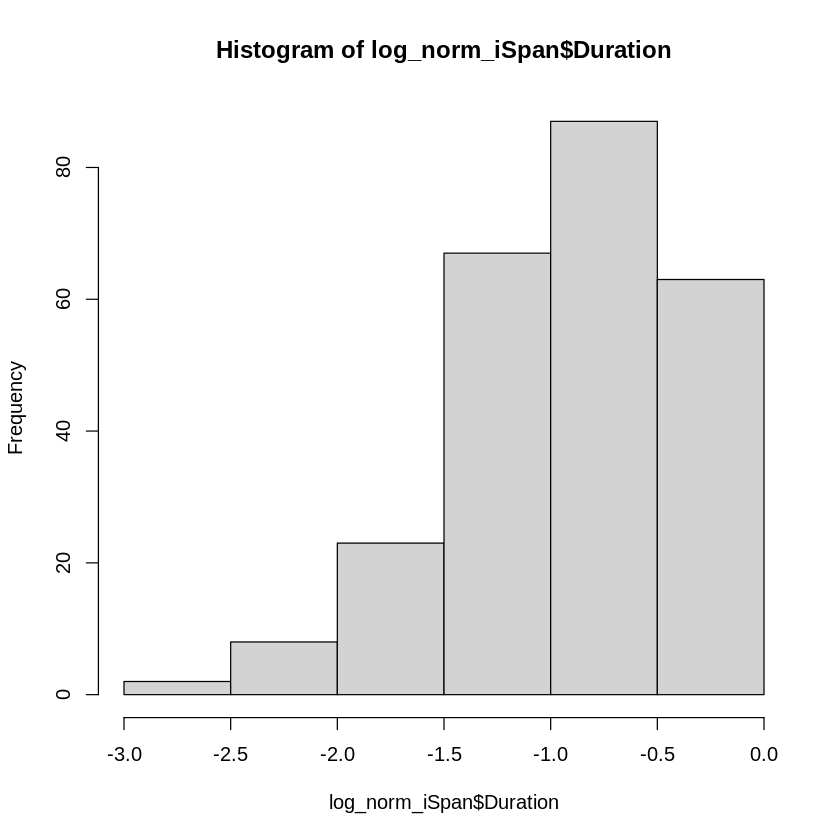

In [103]:
shapiro.test(internalSpanData$Duration)
shapiro.test(dssSpanData$Duration)
shapiro.test(iSpan$Duration)

Normalize_Data <- function(val) { return ((val - min(val)) / (max(val) - min(val))) }

norm_iSpan <- iSpan
norm_iSpan$Duration <- Normalize_Data(norm_iSpan$Duration)

hist(norm_iSpan$Duration, main= 'Normalized Internal Span Duration Histogram')

log_norm_iSpan <- norm_iSpan
log_norm_iSpan$Duration =log10(log_norm_iSpan$Duration)

hist(log_norm_iSpan$Duration)
# qqnorm(log_norm_iSpan$Duration, main="Log Span Duration Q-Q Norm Plot")
# qqline(log_norm_iSpan$Duration)

shapiro.test(norm_iSpan$Duration)

# env0MacI_Subset = subset(cleanMetrics, env == 0)
# shapiro.test(env0MacI_Subset$Duration)
# env1LinI_Subset = subset(cleanMetrics, env == 1)
# shapiro.test(env1LinI_Subset$Duration)
# env2PiI_Subset = subset(cleanMetrics, env == 2)
# shapiro.test(env2PiI_Subset$Duration)
# env3AWS_I_Subset = subset(cleanMetrics, env == 3)
# shapiro.test(env3AWS_I_Subset$Duration)
# env4CCI_I_Subset = subset(cleanMetrics, env == 4)
# shapiro.test(env4CCI_I_Subset$Duration)

### External Data ###

In [104]:
RIC_SpanData = subset(cleanMetrics, Trace.name == "/RIC")
IAD_SpanData = subset(cleanMetrics, Trace.name == "/IAD")

externalSpanData <- rbind(RIC_SpanData, IAD_SpanData)

In [105]:
outliers <- boxplot(externalSpanData$Duration, plot = FALSE)$out
outliers

eSpan <- externalSpanData
eSpan <- eSpan[-which(eSpan$Duration %in% outliers),]

[1] 791 756 824 881 753 824 881 753 812

In [106]:
shapiro.test(externalSpanData$Duration)
shapiro.test(eSpan$Duration)

env0MacE_Subset = subset(cleanMetrics, env == 0)
shapiro.test(env0MacE_Subset$Duration)
env1LinE_Subset = subset(cleanMetrics, env == 1)
shapiro.test(env1LinE_Subset$Duration)
env2PiE_Subset = subset(cleanMetrics, env == 2)
shapiro.test(env2PiE_Subset$Duration)
env3AWS_E_Subset = subset(cleanMetrics, env == 3)
shapiro.test(env3AWS_E_Subset$Duration)
env4CCI_E_Subset = subset(cleanMetrics, env == 4)
shapiro.test(env4CCI_E_Subset$Duration)


	Shapiro-Wilk normality test

data:  externalSpanData$Duration
W = 0.85885, p-value = 1.398e-12



	Shapiro-Wilk normality test

data:  eSpan$Duration
W = 0.88201, p-value = 4.995e-11



	Shapiro-Wilk normality test

data:  env0MacE_Subset$Duration
W = 0.78089, p-value = 7.724e-11



	Shapiro-Wilk normality test

data:  env1LinE_Subset$Duration
W = 0.74353, p-value = 6.337e-12



	Shapiro-Wilk normality test

data:  env2PiE_Subset$Duration
W = 0.74353, p-value = 6.337e-12



	Shapiro-Wilk normality test

data:  env3AWS_E_Subset$Duration
W = 0.73428, p-value = 3.67e-12



	Shapiro-Wilk normality test

data:  env4CCI_E_Subset$Duration
W = 0.74182, p-value = 6.676e-12


This result looks much better.  However, we'll remove internal span outliers.

In [107]:
# par(mfrow=c(1,3))
# # hist(externalSpanData$Duration)
# # boxplot(externalSpanData$Duration~externalSpanData$Trace.name, notch=TRUE)
# hist(eSpan$Duration)
# boxplot(eSpan$Duration~eSpan$Trace.name, notch=TRUE)
# boxplot(eSpan$Duration~eSpan$env, notch=TRUE)

#### Data Transformations ####

##### Sqrt-Log-Cube Transformations #####

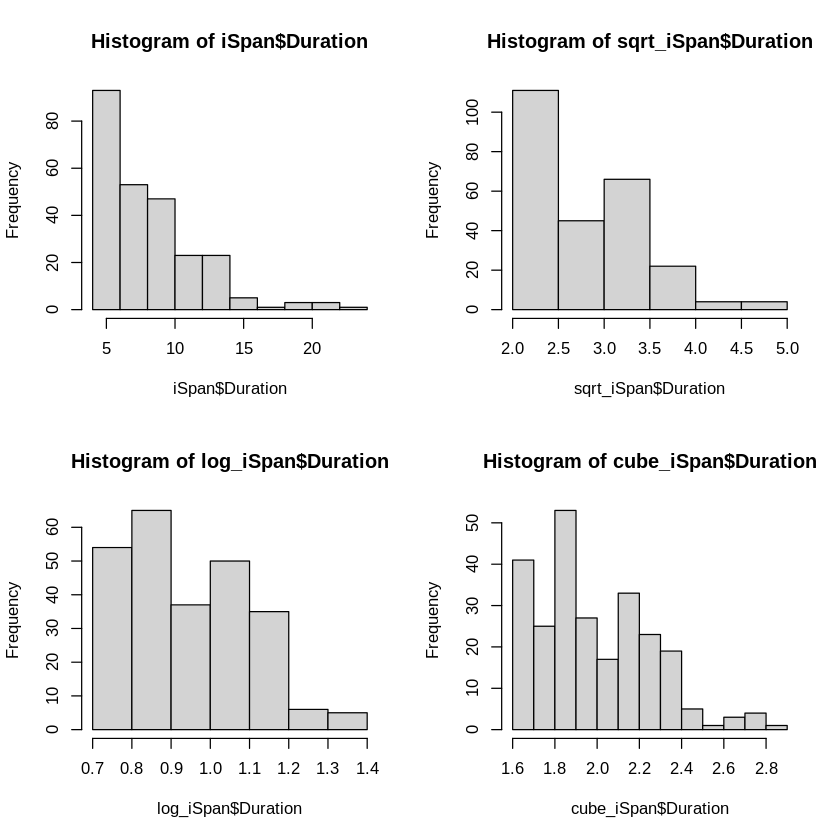

In [108]:
sqrt_iSpan <- iSpan
sqrt_iSpan$Duration=sqrt(sqrt_iSpan$Duration)
log_iSpan <- iSpan
log_iSpan$Duration=log10(log_iSpan$Duration + 1)
cube_iSpan <- iSpan
cube_iSpan$Duration=cube_iSpan$Duration^(1/3)

par(mfrow=c(2,2))
hist(iSpan$Duration, counts = 5)
hist(sqrt_iSpan$Duration, counts = 0.5)
hist(log_iSpan$Duration, counts = 0.5)
hist(cube_iSpan$Duration, counts = 0.5)

##### Q-Q Norm Sqrt-Log-Cube #####

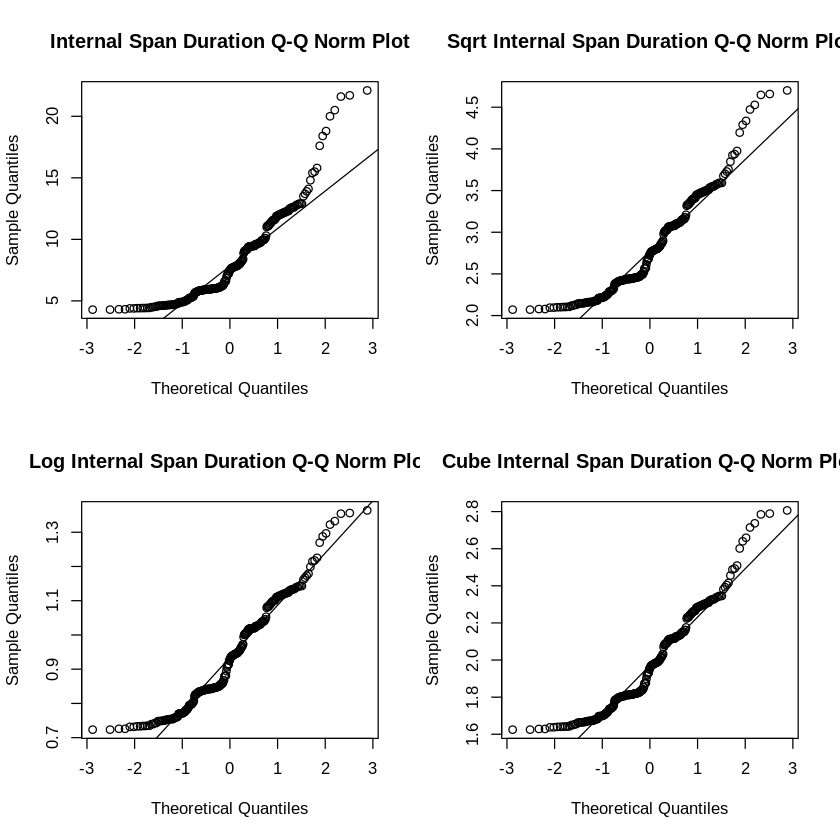

In [109]:
par(mfrow=c(2,2))
qqnorm(iSpan$Duration,main="Internal Span Duration Q-Q Norm Plot")
qqline(iSpan$Duration)
qqnorm(sqrt_iSpan$Duration,main="Sqrt Internal Span Duration Q-Q Norm Plot")
qqline(sqrt_iSpan$Duration)
qqnorm(log_iSpan$Duration,main="Log Internal Span Duration Q-Q Norm Plot")
qqline(log_iSpan$Duration)
qqnorm(cube_iSpan$Duration,main="Cube Internal Span Duration Q-Q Norm Plot")
qqline(cube_iSpan$Duration)

In [110]:
shapiro.test(log_iSpan$Duration)


	Shapiro-Wilk normality test

data:  log_iSpan$Duration
W = 0.94448, p-value = 3.486e-08


#### Box-Cox Transformation ####

Box and Cox (1964) developed a family of transformations designed to reduce nonnormality of the errors in a linear model. Applying this transform often reduces non-linearity as well, and heteroscedascity.

The idea is to transform the response variable $Y$ to a replacement response variable $Y_i^{(\lambda)}$, leaving the right-hand side of the regression model unchanged, so that the regression residuals become normally-distributed. Note that the regression coefficients will also change, because the response variable has changed; therefore, the regression coefficients must be interpreted with respect to the transformed variable. Also, any predictions made with the model have to be back-transformed, to be interpreted in the original units.

The standard (simple) Box-Cox transform is:

$$
    Y_i^{(\lambda)}=
\begin{cases}
{\frac {Y_i^\lambda - 1} \lambda},  & {(\lambda \neq 0)} \\
log(Y_i), & {(\lambda = 0)}
\end{cases}
$$

_Box, G. E. P., & Cox, D. R. (1964). An Analysis of Transformations. Journal of the Royal Statistical Society, Series B (Metholodogical), 26(2), 211-252._

http://www.css.cornell.edu/faculty/dgr2/_static/files/R_html/Transformations.html

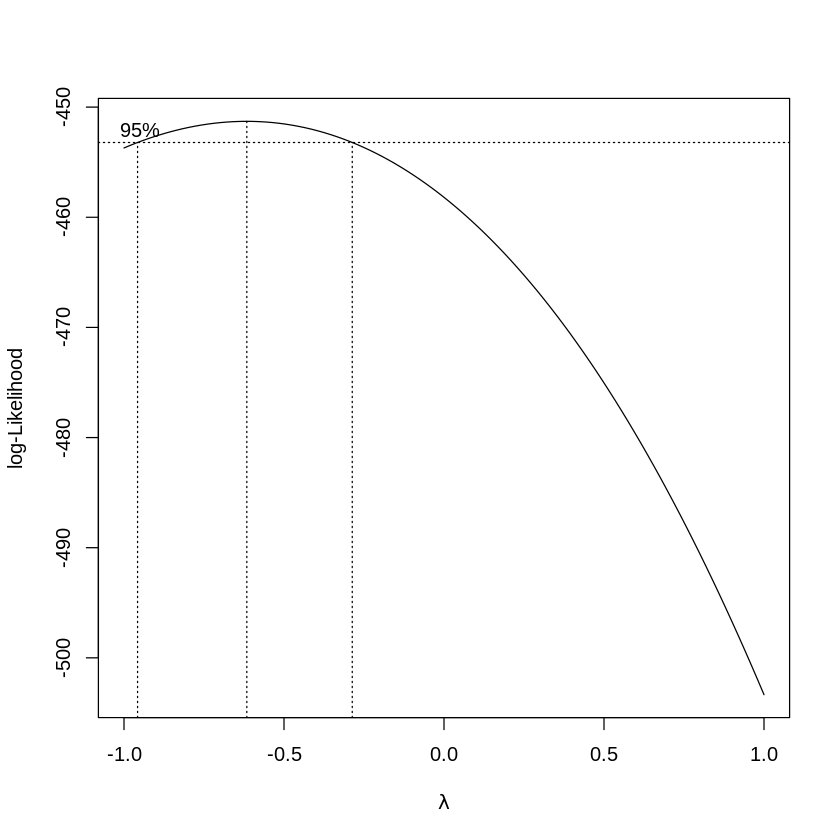

In [111]:
bcData = iSpan
x <- bcData$Duration
bc = boxcox(lm(x ~ 1), seq(-1,1,.1))
#bc = boxcox(lm(x ~ 1))
lambda <- bc$x[which.max(bc$y)]
new_x_exact <- (x ^ lambda - 1) / lambda

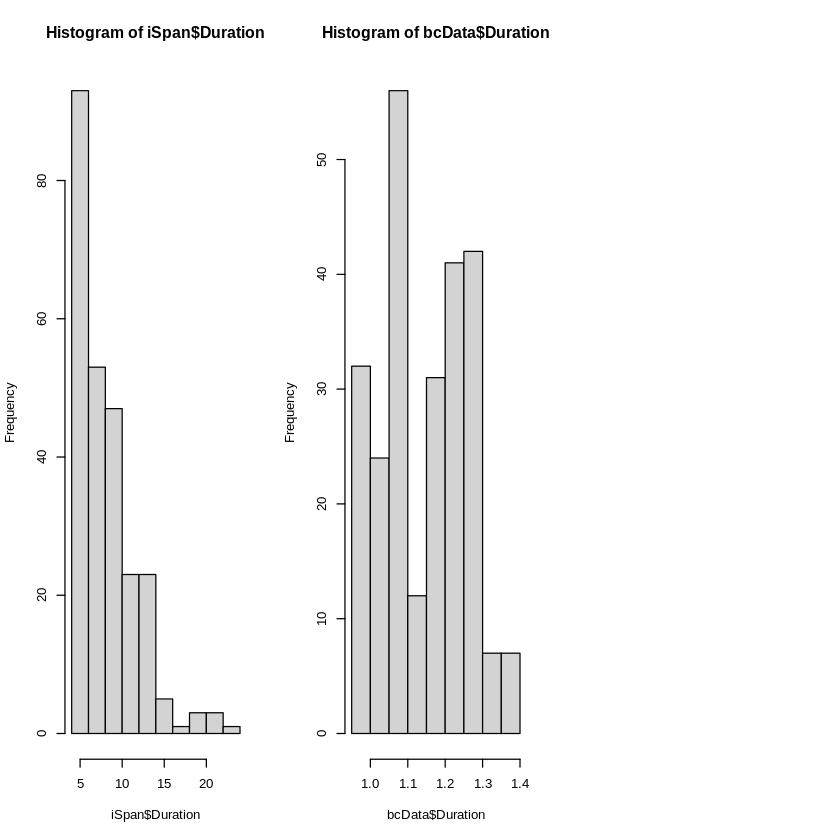

In [112]:
bcData$Duration = new_x_exact
par(mfrow=c(1,3))
hist(iSpan$Duration)
hist(bcData$Duration)

### Normality Testing of the Trasformation ###

#### Shapiro-Wilk ####

The null-hypothesis of this test is that the population is normally distributed. Thus, if the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected (e.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population).

https://en.wikipedia.org/wiki/Shapiro–Wilk_test

In [113]:
shapiro.test(bcData$Duration)


	Shapiro-Wilk normality test

data:  bcData$Duration
W = 0.95906, p-value = 1.416e-06


With p-value of 2.852e-08 < 0.05 we reject the null hypothesis that the data are from a normally distributed population. But we'll also do a Q-Q Norm plot to visually see the results.

_"if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected"_

##### Shapiro-Wilk Testing Sqrt-Log-Cube #####

In [114]:
shapiro.test(sqrt_iSpan$Duration)
shapiro.test(log_iSpan$Duration)
shapiro.test(cube_iSpan$Duration)


	Shapiro-Wilk normality test

data:  sqrt_iSpan$Duration
W = 0.92011, p-value = 2.208e-10



	Shapiro-Wilk normality test

data:  log_iSpan$Duration
W = 0.94448, p-value = 3.486e-08



	Shapiro-Wilk normality test

data:  cube_iSpan$Duration
W = 0.93233, p-value = 2.422e-09


The **cube transformation** seems to provide the best q-q plot fit. With a p-value of 0.3593 > 0.05 we fail to reject the null hypothesis and assume we now have a normal distribution. 

_"if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected"_

<!-- #### Box-Cox Transformation #### -->

#### Autocorrelation ####

Autocorrelation plots are a commonly-used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.

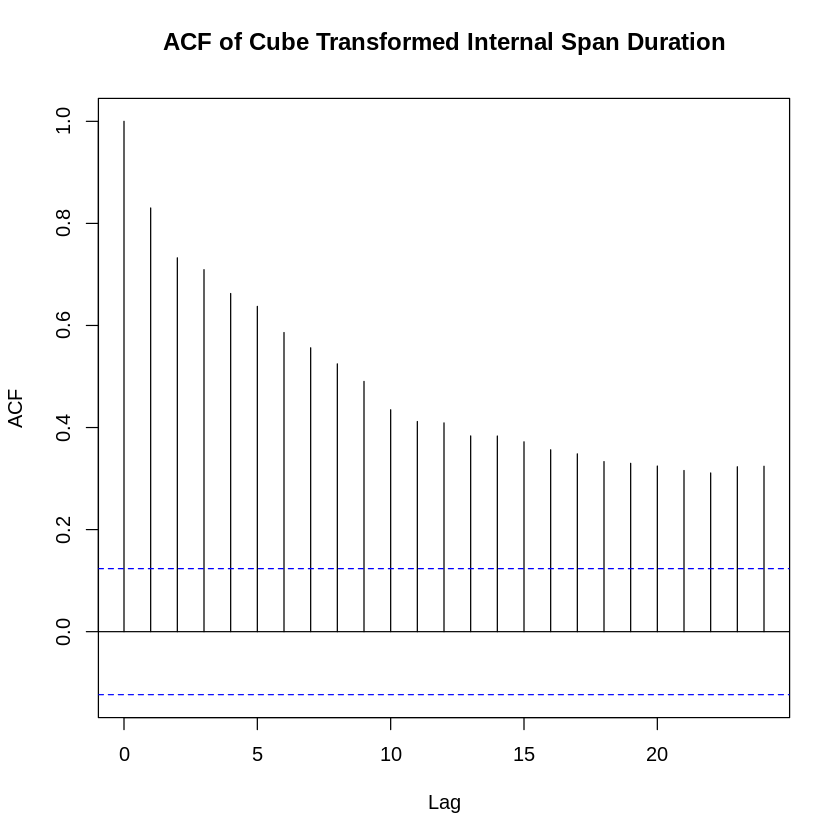

In [115]:
acf(cube_iSpan$Duration, main="ACF of Cube Transformed Internal Span Duration")

The ACF indicates that the data is random since the results are near zero.

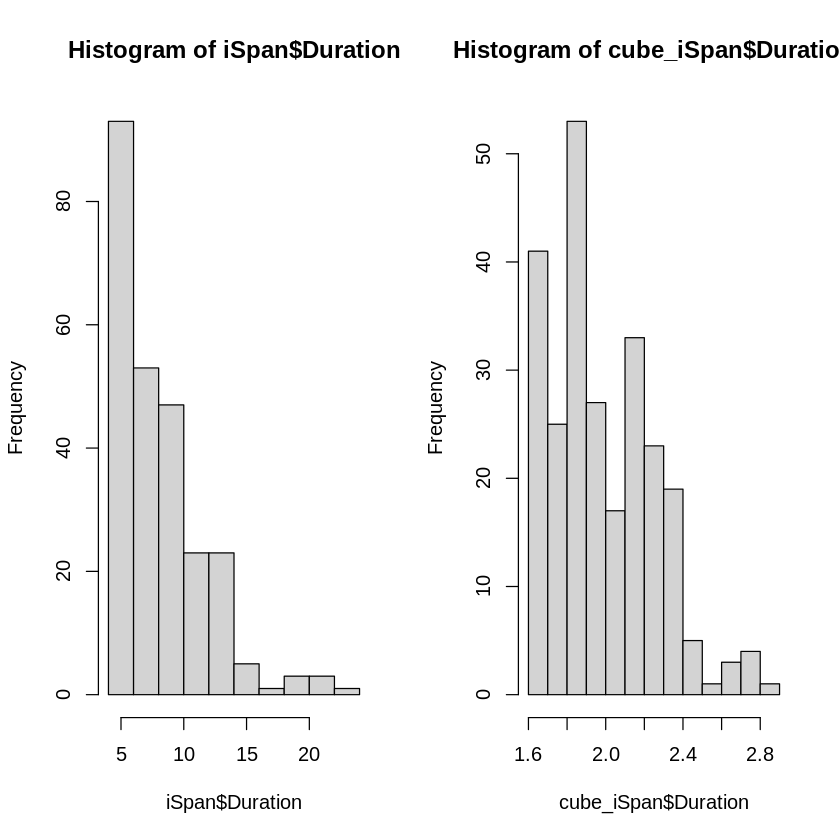

In [116]:
par(mfrow=c(1,2))
hist(iSpan$Duration, counts=5)
hist(cube_iSpan$Duration, counts=0.5)

<!-- With a Box-Cox transformation with a p-value of 0.05123 > 0.05 we fail to reject the null hypothesis, i.e. we assume that we now have a normal distribution. -->

#### Hypothesis Testing ####

We will use a Student's t-Test to test the hypothesis on **normal** internal span data. Our mean is 500 ms (e.g. $\mu = 0.5$ seconds) and our null hypthesis is less than 500 ms.

In [117]:
mu = 0.5
x = cube_iSpan$Duration
cube_mu = mu^(1/3)
t.test(x=x, mu=cube_mu, alternative = 'greater')


	One Sample t-test

data:  x
t = 71.201, df = 251, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0.7937005
95 percent confidence interval:
 1.955862      Inf
sample estimates:
mean of x 
 1.983448 


In [118]:
mu = 0.5
x = iSpan$Duration
t.test(x=x, mu=mu, alternative = 'greater')


	One Sample t-test

data:  x
t = 34.699, df = 251, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 7.865648      Inf
sample estimates:
mean of x 
 8.233611 


With a original and transformation with a p-value of 1 > 0.05 we fail to reject the null hypothesis, i.e. we assume that latency will be less than 500 ms.

_"If the p value is greater than the chosen alpha level, then the null hypothesis (that latency is < 500 ms) can not be rejected"_

### External Data ###

#### Q-Q Norm Plot of "Clean" External Span Data ####

We'll look a the Q-Q Norm Plot and Shapiro-Wilk Test

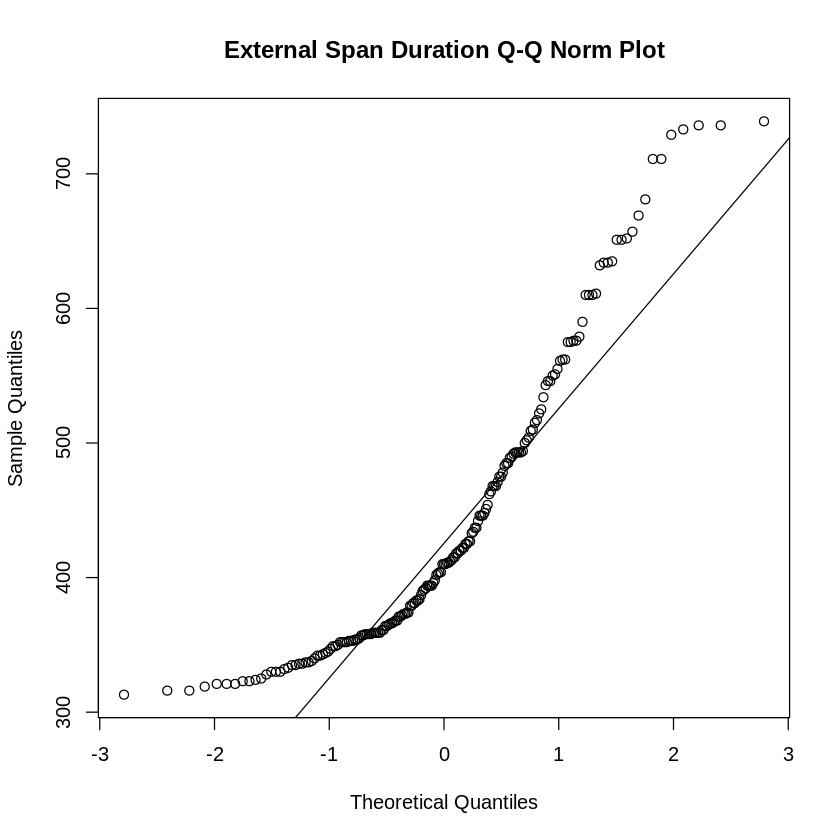

In [119]:
qqnorm(eSpan$Duration, main="External Span Duration Q-Q Norm Plot")
qqline(eSpan$Duration)

#### Shapiro-Wilk Normality Test ####

In [120]:
shapiro.test(eSpan$Duration)


	Shapiro-Wilk normality test

data:  eSpan$Duration
W = 0.88201, p-value = 4.995e-11


With a p-value of 0.2878 > 0.05 we fail to reject the null hypothesis, i.e. we assume that we have a normal distribution.

_"if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected"_

#### Autocorrelation ####

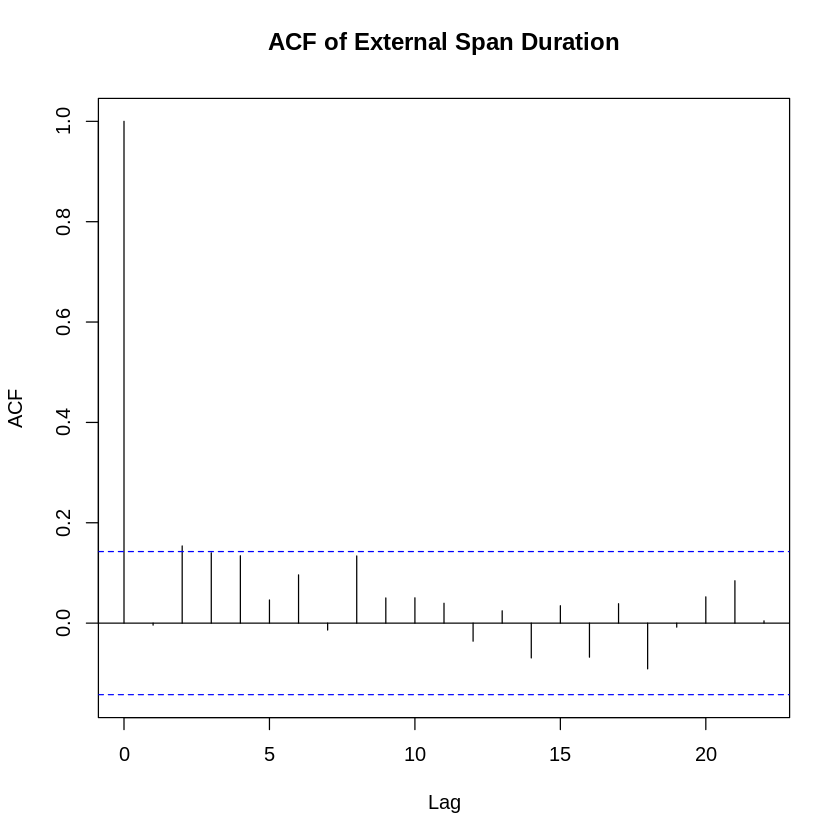

In [121]:
acf(eSpan$Duration, main="ACF of External Span Duration")

The ACF indicates that the data is random since the results are near zero.

<!-- The log transformation yields the best fit so we we shall use it moving forward.

The **log transformation** with a p-value of 0.1643 > 0.05. We now have a normal distribution. -->

#### Hypothesis Testing ####

We will use a Student's t-Test to test the hypothesis on external span data. Our mean is 500 ms (e.g. $\mu = 0.5$ seconds) and our null hypthesis is less than 500 ms.

In [122]:
mu = 0.5

In [123]:
x = eSpan$Duration
t.test(x=x, mu=mu, alternative = 'greater')


	One Sample t-test

data:  x
t = 56.515, df = 188, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 427.8283      Inf
sample estimates:
mean of x 
 440.7037 


With a p-value of 0.1336 > 0.05 we fail to reject the null hypothesis, i.e. we assume that 500 ms can be maintained for external service requests.

_"If the p value is greater than the chosen alpha level, then the null hypothesis (that latency is < 500 ms) can not be rejected"_

## Observations ##

### General Discussion of Normality ###
It was required to separate external data from internal to establish normality of the data samples. The internal data set required transformation to establish normality, while the external data did not require a transformation. 

### Hypothesis Results ###

Hypothesis testing using the Student's t-Test indicates that latency constraints of 500 ms can be maintained internally and external. However, serveral external samples were greater than 500 ms. This is most likely due to the non-deterministic nature of internet (e.g. http) requests. Within the internal environment, data is directly routed between microservices within the Docker environment within a private network. The data shows that a container based microservice architecture can meet the requirement; however, care must be taken to manage processing per container that may increase container response times.